# Подготовка модели распознавания рукописных букв и цифр

In [45]:
# !pip install torchvision torchinfo

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import EMNIST

In [71]:
train_dataset = EMNIST('data/', 'balanced', train=True, download=False)
val_dataset = EMNIST('data/', 'balanced', train=False, download=False)

with open('emnist-balanced-mapping.txt', 'r') as file:
    content = file.read()
lines = content.strip().split('\n')
labels_dict = {int(lines[i].split(' ')[0]): chr(int(lines[i].split(' ')[1])) for i in range(len(lines))}

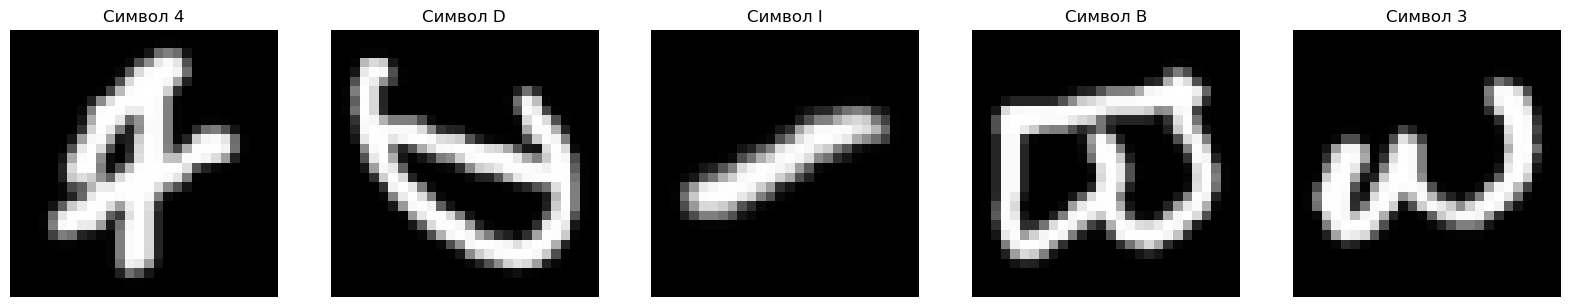

In [72]:
fig, ax = plt.subplots(1, 5, figsize=(20, 12))

rand_numbers = [random.randint(1, 112800) for _ in range(5)]
for i in range(5):
    ax[i].imshow(train_dataset[rand_numbers[i]][0], cmap='gray')
    ax[i].set_title(f'Символ {labels_dict[train_dataset[rand_numbers[i]][1]]}')
    ax[i].axis('off')
plt.show()

In [73]:
transform = Compose([
    ToTensor(),
    Normalize([0.5], [0.5])
])
train_dataset = EMNIST('data/', 'balanced', train=True, download=False, transform=transform)
val_dataset = EMNIST('data/', 'balanced', train=False, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [74]:
class CNN(nn.Module):
    def __init__(self, n_classes=47):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), padding=1), #(batch_size, 1, 28, 28) -> (batch_size, 32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), #(batch_size, 1, 28, 28) -> (batch_size, 32, 14, 14)
            nn.Conv2d(32, 64, (3, 3)), #(batch_size, 32, 14, 14) -> (batch_size, 64, 12, 12)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), #(batch_size, 64, 12, 12) -> (batch_size, 64, 6, 6)
            nn.Flatten(), #(batch_size, 64, 6, 6) -> (batch_size, 64*6*6)
            nn.Linear(64*6*6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )
       
    def forward(self, x):
        return self.model(x)       

In [75]:
def train(model, optimizer, loss_fn, train_loader, val_loader, n_epoch, val_fre):
    
    model.train()
    for epoch in range(1, n_epoch + 1):
        loss_sum = 0
        print(f'Epoch: {epoch}')
        for step, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data).squeeze(1)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()

            if step % 10 == 0:
                print(f'Iter: {step} \tLoss: {loss.item()}')

        print(f'Mean Train Loss: {loss_sum / (step + 1):.6f}', end='\n\n')

        if epoch % val_fre == 0:
            validate(model, val_loader, epoch)

def validate(model, val_loader, epoch):
        
    model.eval()
    loss_sum = 0
    correct = 0
    for step, (data, target) in enumerate(val_loader):
        with torch.no_grad():
            output = model(data).squeeze(1)
            loss = loss_fn(output, target)
        loss_sum += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(val_loader.dataset)
    
    mean_val_loss = loss_sum / (step + 1)
    
    if epoch > 19:
        torch.save(model.state_dict(), f'myapp/cnn_epoch_{epoch}.pth')
        print(f'На эпохе {epoch} параметры модели были сохранены при наилучшем значении функции потерь {mean_val_loss:.6f} на валидационной выборке.')
        print(f'Метрика Accuracy: {acc:.4f}.')
    else:    
        print(f'Функция потерь: {mean_val_loss:.6f} \tМетрика Accuracy: {acc:.4f}')
    model.train()

In [76]:
clf = CNN()
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(clf.parameters(), lr=0.0001)
n_epoch = 50
val_fre = 2

In [77]:
train(clf, opt, loss_fn, train_loader, val_loader, n_epoch, val_fre)

Epoch: 1
Iter: 0 	Loss: 3.8641529083251953
Iter: 10 	Loss: 3.6765568256378174
Iter: 20 	Loss: 3.436800003051758
Iter: 30 	Loss: 3.164767026901245
Iter: 40 	Loss: 2.829808235168457
Iter: 50 	Loss: 2.48492693901062
Iter: 60 	Loss: 2.162473440170288
Iter: 70 	Loss: 1.9471747875213623
Iter: 80 	Loss: 1.7833251953125
Iter: 90 	Loss: 1.5572558641433716
Iter: 100 	Loss: 1.4266886711120605
Iter: 110 	Loss: 1.1132619380950928
Mean Train Loss: 2.464007

Epoch: 2
Iter: 0 	Loss: 1.3245621919631958
Iter: 10 	Loss: 1.2456772327423096
Iter: 20 	Loss: 1.246539831161499
Iter: 30 	Loss: 1.0912902355194092
Iter: 40 	Loss: 1.0607794523239136
Iter: 50 	Loss: 1.0026299953460693
Iter: 60 	Loss: 0.9868945479393005
Iter: 70 	Loss: 0.9472066760063171
Iter: 80 	Loss: 0.9264494776725769
Iter: 90 	Loss: 0.8692208528518677
Iter: 100 	Loss: 0.8750441670417786
Iter: 110 	Loss: 0.8021543622016907
Mean Train Loss: 1.034585

Функция потерь: 0.719629 	Метрика Accuracy: 0.7872
Epoch: 3
Iter: 0 	Loss: 0.8885976076126099
It